In [ ]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image
models.res

In [2]:
data_dir = './data_3'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),#标准化图片
        transforms.RandomRotation(45),                  #随机旋转，-45到45度之间随机选
        transforms.CenterCrop(224),                     #从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),         #随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),           #随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),            #概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'valid': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [21]:
batch_size = 5220
CLASS = 3
#构建数据集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [20]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5216
     Root location: ./data_3\train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 624
     Root location: ./data_3\valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 

In [9]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
cat_to_name

{'1': 'BACTERIA', '2': 'NORMAL', '3': 'VIRUS'}

In [11]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

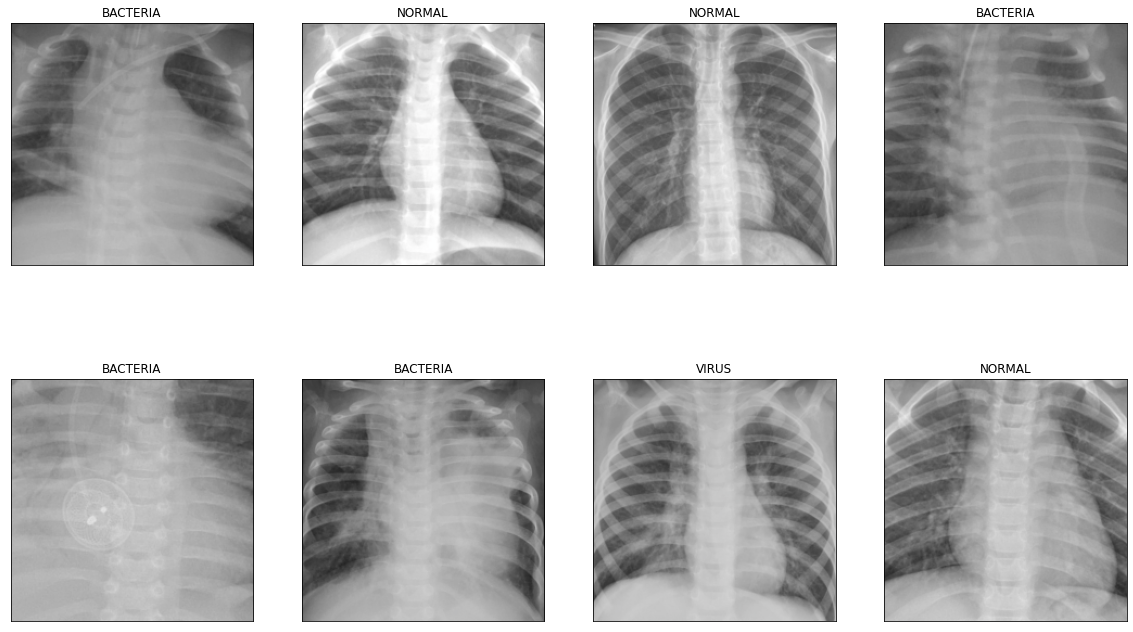

In [12]:
fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [22]:
dataiter1 = iter(dataloaders["train"])
images, labels = dataiter1.next()

5216

In [23]:
train_X = images
train_Y = labels

In [24]:
dataiter_val = iter(dataloaders["valid"])
valid_X, valid_Y = dataiter_val.next()

In [33]:
train_X.flatten(2,3)

tensor([[[-0.6623, -0.6794, -0.6623,  ..., -1.1247, -1.1418, -1.1247],
         [-0.5476, -0.5651, -0.5476,  ..., -1.0203, -1.0378, -1.0203],
         [-0.3230, -0.3404, -0.3230,  ..., -0.7936, -0.8110, -0.7936]],

        [[ 0.3309,  0.3138,  0.3309,  ..., -0.0972, -0.1143, -0.1828],
         [ 0.4678,  0.4503,  0.4678,  ...,  0.0301,  0.0126, -0.0574],
         [ 0.6879,  0.6705,  0.6879,  ...,  0.2522,  0.2348,  0.1651]],

        [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]],

        ...,

        [[-0.4397, -0.4397, -0.4397,  ...,  0.7419,  0.7248,  0.7762],
         [-0.3200, -0.3200, -0.3200,  ...,  0.8880,  0.8704,  0.9230],
         [-0.0964, -0.0964, -0.0964,  ...,  1.1062,  1.0888,  1.1411]],

        [[ 1.2728,  1.2899,  1.2899,  ...,  1.0673,  1.0331,  0.9817],
         [ 1.4307,  1.4482,  1.4482,  ...,  1.2206,  1.

In [35]:
source_x = train_X
source_x = (source_x.reshape(source_x.shape[0], source_x.shape[1] * source_x.shape[2] * source_x.shape[3]))
train_X = source_x

# 二分类

In [61]:
train_Y_2 = train_Y
valid_Y_2 = valid_Y
for i in range(len(train_Y_2)):
    if train_Y_2[i] == 0 or train_Y_2[i] == 2:
        train_Y_2[i] = 1
    else:
        train_Y_2[i] = 0
        
for i in range(len(valid_Y_2)):
    if valid_Y_2[i] == 0 or valid_Y_2[i] == 2:
        valid_Y_2[i] = 1
    else:
        valid_Y_2[i] = 0

In [62]:
from sklearn import tree
clf_2 = tree.DecisionTreeClassifier()
clf_2.fit(train_X, train_Y_2)

DecisionTreeClassifier()

In [64]:
result = clf.score(valid_X, valid_Y)
y_pred_gbc = clf_2.predict_proba(train_X)[:,1]
y_2 = clf_2.predict(valid_X)
result

0.7291666666666666

In [65]:
from sklearn.metrics import classification_report
print(classification_report(valid_Y, y))

              precision    recall  f1-score   support

           0       0.77      0.40      0.52       234
           1       0.72      0.93      0.81       390

    accuracy                           0.73       624
   macro avg       0.74      0.66      0.67       624
weighted avg       0.74      0.73      0.70       624



# 三分类

In [37]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(train_X, train_Y)

DecisionTreeClassifier()

In [54]:
clf.predict_proba(valid_X)

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [38]:
source_x = valid_X
source_x = (source_x.reshape(source_x.shape[0], source_x.shape[1] * source_x.shape[2] * source_x.shape[3]))
valid_X = source_x

In [55]:
result = clf.score(valid_X, valid_Y)
y_pred_gbc = clf.predict_proba(train_X)[:,1]
y = clf.predict(valid_X)
result

0.5592948717948718

In [56]:
from sklearn.metrics import classification_report
print(classification_report(valid_Y, y))

              precision    recall  f1-score   support

           0       0.55      0.74      0.63       242
           1       0.78      0.47      0.59       234
           2       0.39      0.41      0.40       148

    accuracy                           0.56       624
   macro avg       0.57      0.54      0.54       624
weighted avg       0.60      0.56      0.56       624

